In [195]:
import pandas as pd
from pandas import Series
from pandas import concat
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding,Flatten,Dropout, Dense, Concatenate, TimeDistributed, Bidirectional,Attention
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

In [111]:
def create_dataset(dataset, look_back=8):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [112]:
df=pd.read_csv('abalone.data',names=['Sex'
,'Length'
,'Diameter'
,'Height'
,'Whole weight'
,'Shucked weight'
,'Viscera weight'
,'Shell weight'
,'Rings'])

df.reset_index(inplace=True)

df['Age']=df['Rings'].apply(lambda x: x/1.5)


encoder=LabelEncoder()
df['Sex']=encoder.fit_transform(df['Sex'])
print(df)



      index  Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0         0    2   0.455     0.365   0.095        0.5140          0.2245   
1         1    2   0.350     0.265   0.090        0.2255          0.0995   
2         2    0   0.530     0.420   0.135        0.6770          0.2565   
3         3    2   0.440     0.365   0.125        0.5160          0.2155   
4         4    1   0.330     0.255   0.080        0.2050          0.0895   
...     ...  ...     ...       ...     ...           ...             ...   
4172   4172    0   0.565     0.450   0.165        0.8870          0.3700   
4173   4173    2   0.590     0.440   0.135        0.9660          0.4390   
4174   4174    2   0.600     0.475   0.205        1.1760          0.5255   
4175   4175    0   0.625     0.485   0.150        1.0945          0.5310   
4176   4176    2   0.710     0.555   0.195        1.9485          0.9455   

      Viscera weight  Shell weight  Rings        Age  
0             0.1010        0.15

In [113]:
raw_values = df.values
#diff_values = difference(raw_values, 1)

features=10
#supervised = timeseries_to_supervised(diff_values, features)
supervised = timeseries_to_supervised(raw_values, features)
supervised_values = supervised.values[features:,:]

train_size = int(len(df) * 0.70)
test_size = len(df) - train_size

# split data into train and test-sets
train, test = supervised_values[0:-train_size, :], supervised_values[-train_size:, :]



[[9.00000000e+00 0.00000000e+00 5.50000000e-01 ... 2.10000000e-01
  1.40000000e+01 9.33333333e+00]
 [1.00000000e+01 0.00000000e+00 5.25000000e-01 ... 1.35000000e-01
  1.00000000e+01 6.66666667e+00]
 [1.10000000e+01 2.00000000e+00 4.30000000e-01 ... 1.90000000e-01
  1.10000000e+01 7.33333333e+00]
 ...
 [1.25000000e+03 1.00000000e+00 4.00000000e-01 ... 7.50000000e-02
  6.00000000e+00 4.00000000e+00]
 [1.25100000e+03 1.00000000e+00 4.05000000e-01 ... 1.70000000e-01
  7.00000000e+00 4.66666667e+00]
 [1.25200000e+03 1.00000000e+00 4.10000000e-01 ... 8.20000000e-02
  6.00000000e+00 4.00000000e+00]]


In [170]:
def model_lstm(X,time_steps=24, n_features=9,
                optimizer = tf.keras.optimizers.Adam,
                learning_rate = 0.001,
                dropout = 0.5,
                n_units_LSTM = 256,
                n_units_1 = 200,
                batch_size=1
              ):
    activation2 = 'relu'
    
    model = Sequential()
    model.add(LSTM(units=n_units_LSTM, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout))
    model.add(Dense(units=n_units_1, activation=activation2))
    model.add(Dense(units=n_units_1, activation=activation2))
    model.add(Dense(units=n_units_1, activation=activation2))
    model.add(Dense(units=n_units_1, activation=activation2))
    model.add(Dense(units=n_units_1, activation=activation2))
    model.add(Dense(1))
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer)
    print(model.summary())
    return model



In [185]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0,shuffle=True)

scaler, train_scaled, test_scaled = scale(train, test)

X_train, y_train = train_scaled[:, 0:-1], train_scaled[:, -1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test, y_test = test_scaled[:, 0:-1], test_scaled[:, -1]
X = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


#print(y)
model=model_lstm(X_train)    
history=model.fit(X_train,y_train, epochs=100)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (1, 256)                  386048    
                                                                 
 dropout_24 (Dropout)        (1, 256)                  0         
                                                                 
 dense_103 (Dense)           (1, 200)                  51400     
                                                                 
 dense_104 (Dense)           (1, 200)                  40200     
                                                                 
 dense_105 (Dense)           (1, 200)                  40200     
                                                                 
 dense_106 (Dense)           (1, 200)                  40200     
                                                                 
 dense_107 (Dense)           (1, 200)                

39/39 [==============================] - 0s 5ms/step - loss: 0.0768
Epoch 82/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0773
Epoch 83/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0770
Epoch 84/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0770
Epoch 85/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0768
Epoch 86/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0770
Epoch 87/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0770
Epoch 88/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0771
Epoch 89/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0769
Epoch 90/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0769
Epoch 91/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0770A: 0s - loss: 0.078
Epoch 92/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0771
Epoch 93/100
39/39 [==

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (1, 256)                  386048    
                                                                 
 dropout_24 (Dropout)        (1, 256)                  0         
                                                                 
 dense_103 (Dense)           (1, 200)                  51400     
                                                                 
 dense_104 (Dense)           (1, 200)                  40200     
                                                                 
 dense_105 (Dense)           (1, 200)                  40200     
                                                                 
 dense_106 (Dense)           (1, 200)                  40200     
                                                                 
 dense_107 (Dense)           (1, 200)                

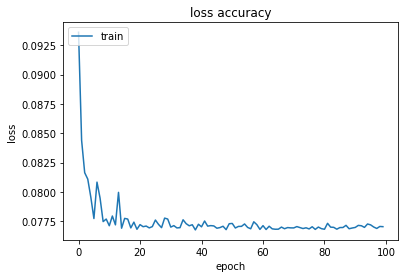

In [186]:
#print("Accuracy",model.evaluate(X_test,y_test))

model.summary()

plt.plot(history.history['loss'])
plt.title('loss accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [203]:
params = {
                'learning_rate' : [0.01, 0.001, 0.0001],
                'n_units_LSTM' : [64,128,256],
                'n_units_1' : [50, 100, 150, 200, 250, 300],
                'dropout' : [0.1, 0.2, 0.25, 0.5]
}
#params={
#    'batch_size':[1]
#}
#scorers = {
#    'accuracy_score' : make_scorer(accuracy_score)
#}
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [10, 50, 100]

param_grid = dict(epochs=epochs, optimizer=optimizer)

#grid_model = KerasClassifier(build_fn=model_lstm(X_train), verbose=0)
#lasso = linear_model.Lasso()
#cv = cross_validate(lasso, X_train, y_train,cv=5)
#start = datetime.now()
#grid = GridSearchCV(estimator = model,                      param_grid = params,                        n_jobs = 1,                        verbose = 1,
#                        cv = cv,                         scoring = scorers,                        refit = 'accuracy_score')
dropout_rate_opts  = [0, 0.2, 0.5]
hidden_layers_opts = [[64, 64, 64, 64], [32, 32, 32, 32, 32], [100, 100, 100]]
l2_penalty_opts = [0.01, 0.1, 0.5]
keras_param_options = {
    'hidden_layers': hidden_layers_opts,
    'dropout_rate': dropout_rate_opts,  
    'l2_penalty': l2_penalty_opts
}
early_stop = EarlyStopping(
    monitor = 'val_loss', min_delta = 0.1, patience = 5, verbose = 0)

callbacks = [early_stop]
keras_fit_params = {   
    'callbacks': callbacks,
    'epochs': 200,
    'batch_size': 2048,
    'verbose': 0
}

Kmodel = KerasClassifier(build_fn=model, 
                         verbose=1,epochs=5)

mse = make_scorer(mean_squared_error,greater_is_better=False)
param_grid = {
    'clf__neurons_input':   [20, 25, 30, 35],
    'clf__batch_size': [40,60,80,100], 
    'clf__optimizer': ['Adam', 'Adadelta']}
grid = GridSearchCV(Kmodel,
                    #param_distributions = keras_param_options,
                    param_grid,
                    #n_iter=3,
                    cv=5,
                    scoring=mse, n_jobs=1)
#grid_result = grid.fit(X_train, y_train,fit_params=keras_fit_params)
grid_result = grid.fit(X_train, y_train)
        
#grid.fit(X_train, y_train)

C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_12900/923052346.py:43: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  Kmodel = KerasClassifier(build_fn=model,


INFO:tensorflow:Assets written to: ram://9841257b-0382-402a-824d-83fb2e8964e2/assets


INFO:tensorflow:Assets written to: ram://9841257b-0382-402a-824d-83fb2e8964e2/assets


NotFoundError: 